
# Emotion Identification

In this notebook, we'll use machine learning to categorise the emotions included in audio recordings. After extracting characteristics from audio recordings with the librosa framework, we will train a neural network to categorise emotions.


## Importing libraries

First, we will start by importing the necessary libraries and ignoring warnings.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import librosa
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from os import listdir

## Extracting audio filenames and emotions

We start by collecting the audio filenames and corresponding emotions in separate lists. The path of the audio files and their emotions are stored in the variables audio_path and audio_emotion respectively. The emotions are extracted from the filenames.


In [2]:
path = 'C:/Users/joelj/OneDrive/Documents/IITH Reseach Teaser-Speech Processing/Emotion Identification/CREMA-D/AudioWAV/'
audio_path = []
audio_emotion = []

In [3]:
# collects all the audio filename in the variable 'path'
directory_path = listdir(path)

In [4]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if emotion[2] == 'SAD':
        audio_emotion.append("sad")
    elif emotion[2] == 'ANG':
        audio_emotion.append("angry")
    elif emotion[2] == 'DIS':
        audio_emotion.append("disgust")
    elif emotion[2] == 'NEU':
        audio_emotion.append("neutral")
    elif emotion[2] == 'HAP':
        audio_emotion.append("happy")
    elif emotion[2] == 'FEA':
        audio_emotion.append("fear")
    else:
        audio_emotion.append("unknown")

In [5]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
#print(len(dataset))
print(dataset.head())
# print(dataset['File Path'][55])

                                                Path Emotions
0  C:/Users/joelj/OneDrive/Documents/IITH Reseach...    angry
1  C:/Users/joelj/OneDrive/Documents/IITH Reseach...  disgust
2  C:/Users/joelj/OneDrive/Documents/IITH Reseach...     fear
3  C:/Users/joelj/OneDrive/Documents/IITH Reseach...    happy
4  C:/Users/joelj/OneDrive/Documents/IITH Reseach...  neutral


## Visualizing emotions

We can visualize the emotions of the audio files using a histogram.

<AxesSubplot: title={'center': 'Emotion Count'}, xlabel='Emotions', ylabel='Count'>

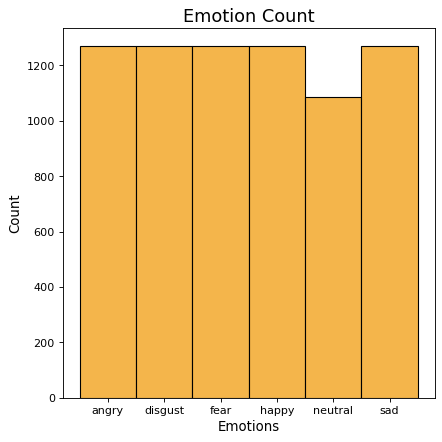

In [6]:
# counting audio categorized by emotions
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')
#plt.show()


## Extracting features from audio files

Now, we will extract the necessary features from the audio files. We will extract the MFCC and Mel features from the audio files and store them in a dataframe along with the emotion label for each audio file.

In [7]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
    # noise injection
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
    # mfcc
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
    # mel
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
    #print(result)
    result = np.array(result)
    X.append(result)
    Y.append(emo)

Feature processing...


In [8]:
# print(X)
# print(Y)
extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)
#print(extracted_audio_df.isna().any())

(7442, 30457)
               0          1          2          3          4          5  \
7432 -691.676433 -66.608213  -3.373386  22.732077  18.859607 -10.212492   
7433 -692.023636 -60.572862   3.818899  14.949758  12.301598 -11.431650   
7434 -742.552505 -36.604282  -8.469167   1.624534  13.186975   7.586315   
7435 -750.874881 -58.121394 -15.539079  16.556214  21.576011 -18.146515   
7436 -644.791432 -76.615987 -18.222448  15.375383  22.741238 -15.780201   
7437 -741.515623 -64.437606   2.094928  10.921220  26.693484  13.394161   
7438 -741.113237 -20.345408 -17.332806  21.312941  13.379471  -7.463377   
7439 -744.692609 -40.974679   5.540676  13.202781   1.621401   4.892782   
7440 -663.407400 -81.592863 -20.581258  13.299165   9.913830  -8.628144   
7441 -827.083656 -14.069783   2.392544  12.806880   3.314845  10.998058   

              6          7          8          9  ...  30447  30448  30449  \
7432 -15.630008   0.144185   6.893599  -9.867546  ...    NaN    NaN    NaN   
7433

## Preparing data for training

Now, we will split the data into training and testing sets and standardize the data using the StandardScaler function.

In [9]:
# preparing to train
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Training the Model

Now, we will create an instance of the MLPClassifier from the sklearn.neural_network library and fit it to the training data.

In [10]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100, 
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
# Fitting mlp model
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

## Evaluating the Model

Now that the model is trained, we will evaluate its performance on the test data. We will use the accuracy_score function from the sklearn.metrics library to calculate the accuracy of the model.

In [11]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 41.24%


## Model Predictions

Finally, we can print out the predictions made by the model on the testing set.

In [12]:
print("The Model's Prediction ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Model's Prediction 
<<<===========================================>>>
       Actual  Predict
6623  disgust  neutral
5244    happy     fear
2737  neutral      sad
3812  disgust      sad
6965    happy    angry
